In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rainfall/rf_2020_to_2024_aug.csv


In [2]:
import importlib
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import clear_output
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import random

#Machine learning related imports
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Lambda, Input, Dropout
from sklearn.metrics import mean_squared_error
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Ensure deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(seed)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
#
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rainfall/rf_2020_to_2024_aug.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/kaggle/input/rainfall/rf_2020_to_2024_aug.csv')  # Update this to your dataset path

# Check the first few rows to understand the structure
print(df.head())



                    system:index  GID_2   NAME_2        date      mean  \
0  20200101_00000000000000000000      8  Wayanad  2020-01-01  2.752560   
1  20200101_00000000000000000001      1  Wayanad  2020-01-01  0.000000   
2  20200101_00000000000000000002      2  Wayanad  2020-01-01  0.000000   
3  20200101_00000000000000000003      3  Wayanad  2020-01-01  0.398158   
4  20200101_00000000000000000004      4  Wayanad  2020-01-01  0.000000   

                                                .geo  
0  {"type":"Polygon","coordinates":[[[76.08240795...  
1  {"type":"Polygon","coordinates":[[[75.77218510...  
2  {"type":"Polygon","coordinates":[[[75.89930315...  
3  {"type":"Polygon","coordinates":[[[76.08240795...  
4  {"type":"Polygon","coordinates":[[[76.01040764...  


In [4]:
def check_column_dtypes(df):
    consistent_dtypes = {}
    for col in df.columns:
        # Get the unique data types of the column
        unique_dtypes = df[col].map(type).unique()
        # Check if there is only one unique dtype
        consistent_dtypes[col] = len(unique_dtypes) == 1
    return consistent_dtypes

# Check column data type consistency
dtype_consistency = check_column_dtypes(df)
print("Column dtype consistency:", dtype_consistency)

Column dtype consistency: {'system:index': True, 'GID_2': True, 'NAME_2': True, 'date': True, 'mean': True, '.geo': True}


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 # Update this to your dataset path

# Check the first few rows to understand the structure
print(df.head())

# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])

# Drop unnecessary columns if not needed for the prediction
df.drop(columns=['system:index', '.geo'], inplace=True)  # Drop .geo as it's not numeric

# Group by date and take the mean rainfall across all GID_2
df_grouped = df.groupby(['date', 'GID_2']).agg({'mean': 'mean'}).reset_index()

# Check the resulting dataset
print(df_grouped.head())

# Pivot the data so that each GID_2 becomes a column, with the 'mean' as values
pivot_df = df_grouped.pivot_table(index='date', columns='GID_2', values='mean')

# Reset the index to make 'date' a column
pivot_df.reset_index(inplace=True)

# Check the pivoted DataFrame
print(pivot_df.head())


                    system:index  GID_2   NAME_2        date      mean  \
0  20200101_00000000000000000000      8  Wayanad  2020-01-01  2.752560   
1  20200101_00000000000000000001      1  Wayanad  2020-01-01  0.000000   
2  20200101_00000000000000000002      2  Wayanad  2020-01-01  0.000000   
3  20200101_00000000000000000003      3  Wayanad  2020-01-01  0.398158   
4  20200101_00000000000000000004      4  Wayanad  2020-01-01  0.000000   

                                                .geo  
0  {"type":"Polygon","coordinates":[[[76.08240795...  
1  {"type":"Polygon","coordinates":[[[75.77218510...  
2  {"type":"Polygon","coordinates":[[[75.89930315...  
3  {"type":"Polygon","coordinates":[[[76.08240795...  
4  {"type":"Polygon","coordinates":[[[76.01040764...  
        date  GID_2      mean
0 2020-01-01      1  0.000000
1 2020-01-01      2  0.000000
2 2020-01-01      3  0.398158
3 2020-01-01      4  0.000000
4 2020-01-01      5  0.000000
GID_2       date    1    2         3    4    

In [6]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1704 non-null   datetime64[ns]
 1   1       1704 non-null   float64       
 2   2       1704 non-null   float64       
 3   3       1704 non-null   float64       
 4   4       1704 non-null   float64       
 5   5       1704 non-null   float64       
 6   6       1704 non-null   float64       
 7   7       1704 non-null   float64       
 8   8       1704 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 119.9 KB


In [7]:
df = pivot_df

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 56)             │         3,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,232 (321.22 KB)

 Trainable params: 82,232 (321.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0140 - mae: 0.0652 - val_loss: 0.0089 - val_mae: 0.0528
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0118 - mae: 0.0651 - val_loss: 0.0088 - val_mae: 0.0508
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0114 - mae: 0.0642 - val_loss: 0.0087 - val_mae: 0.0512
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0113 - mae: 0.0644 - val_loss: 0.0086 - val_mae: 0.0513
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0112 - mae: 0.0645 - val_loss: 0.0086 - val_mae: 0.0514
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0110 - mae: 0.0645 - val_loss: 0.0086 - val_mae: 0.0514
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0109 - mae: 0.0640 - val_loss: 0.0085 - val_mae: 0.0562
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0108 - mae: 0.0643 - val_loss: 0.0085 - val_mae: 0.0548
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.010

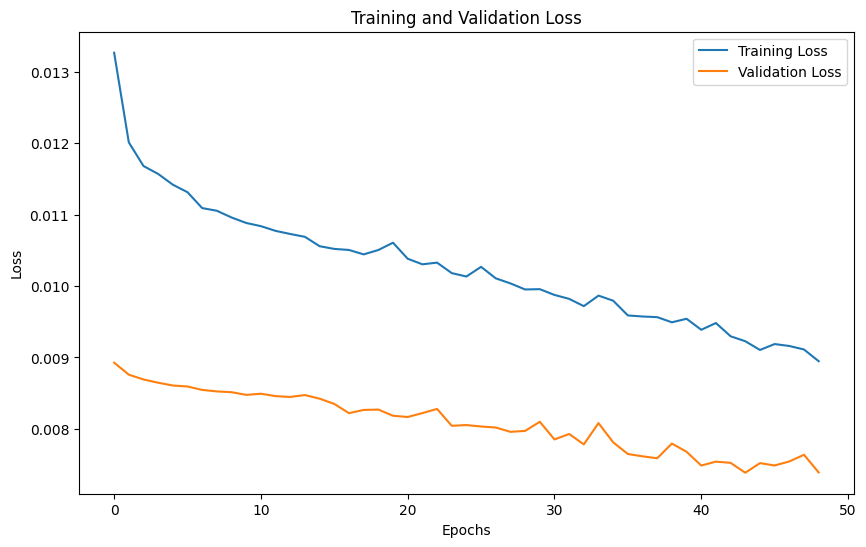

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


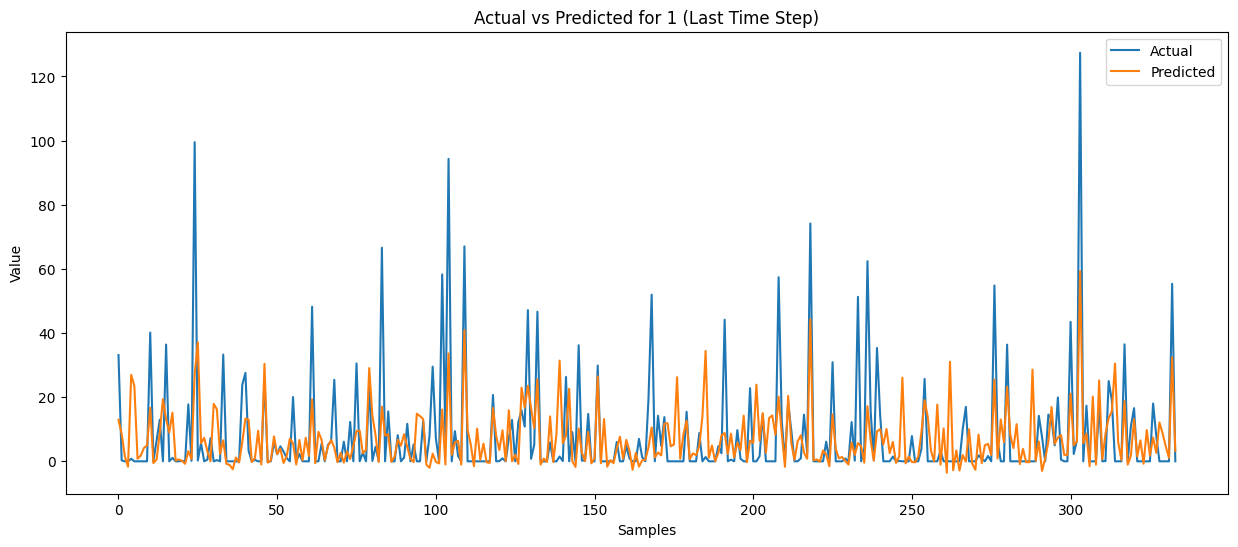

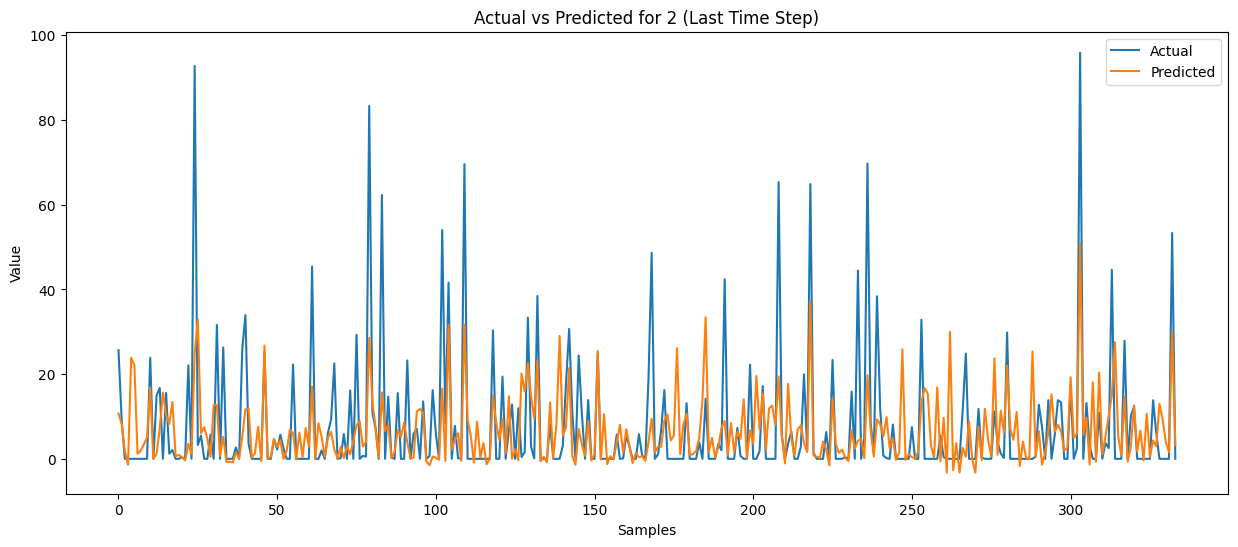

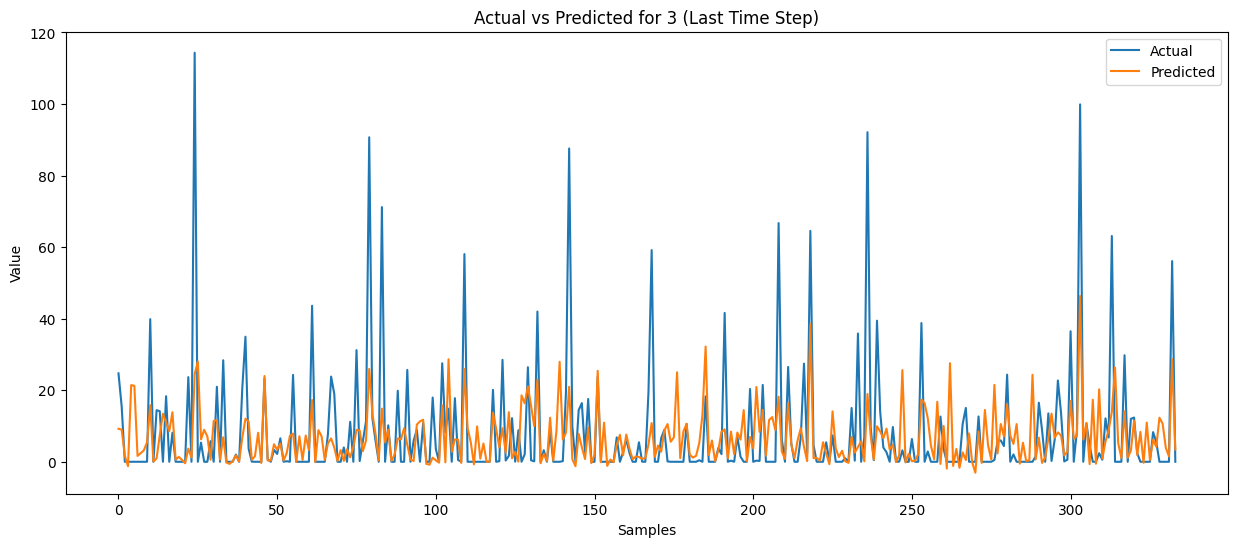

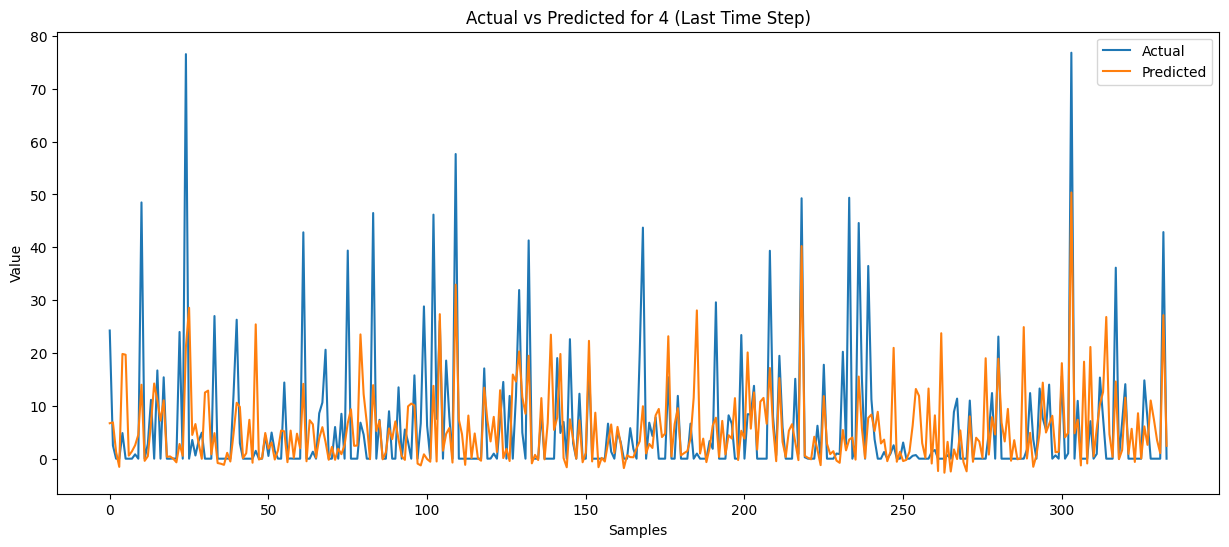

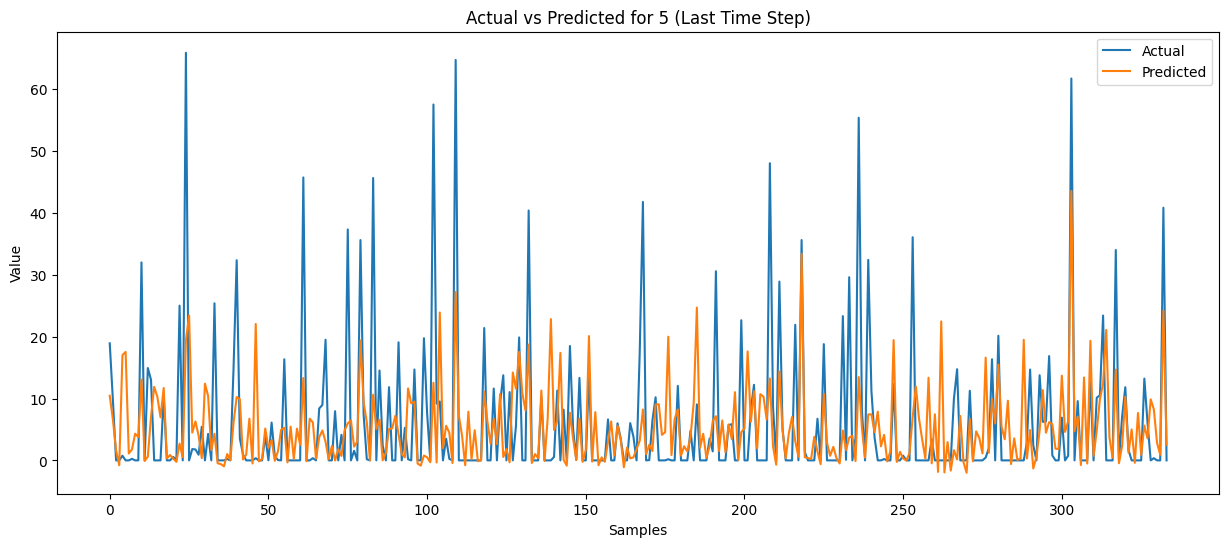

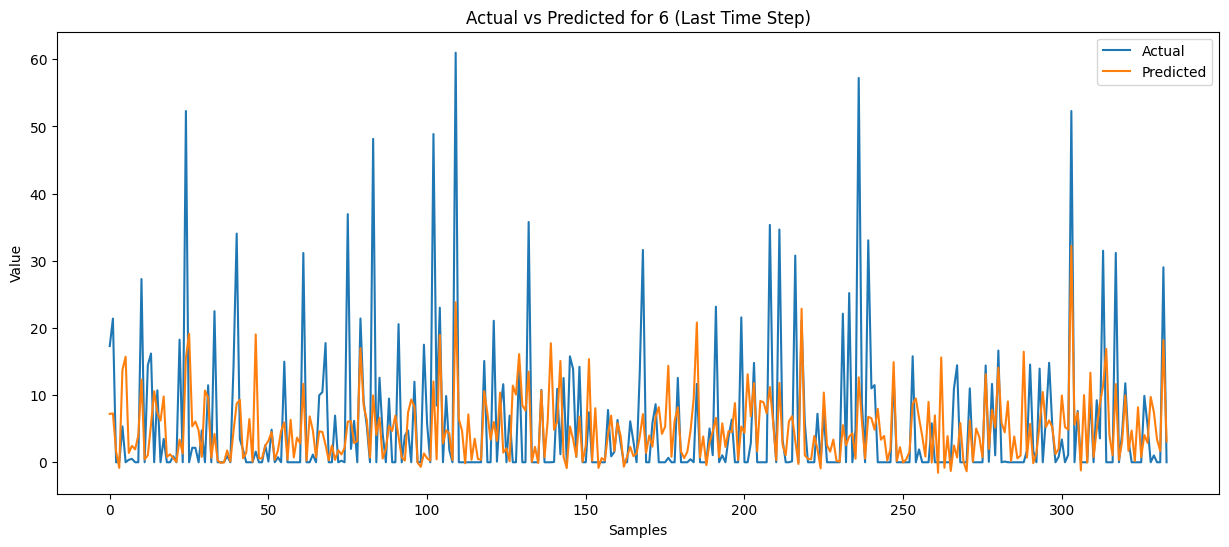

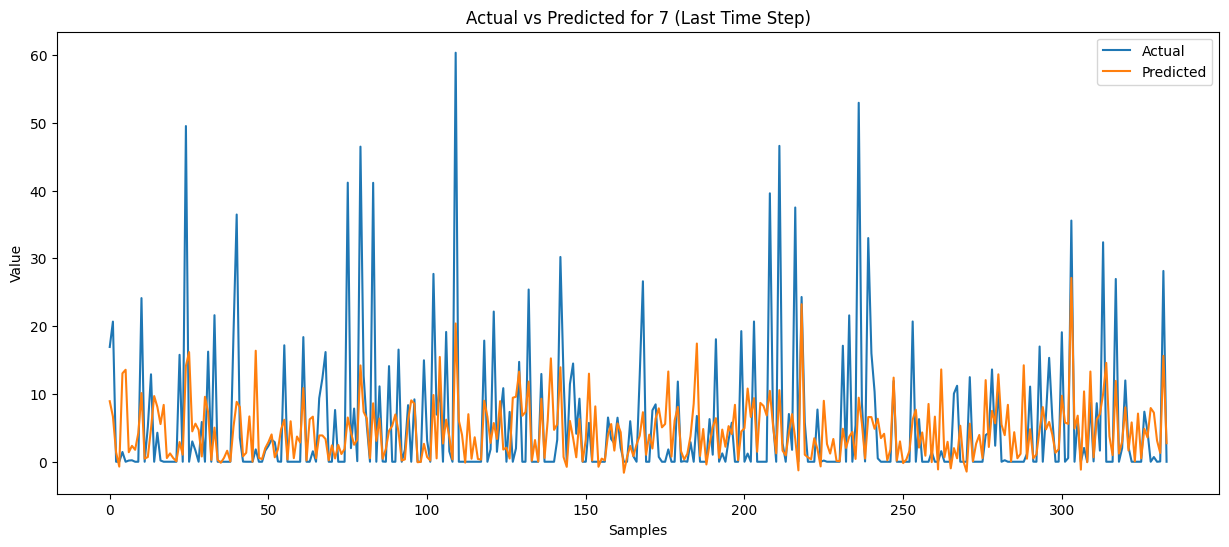

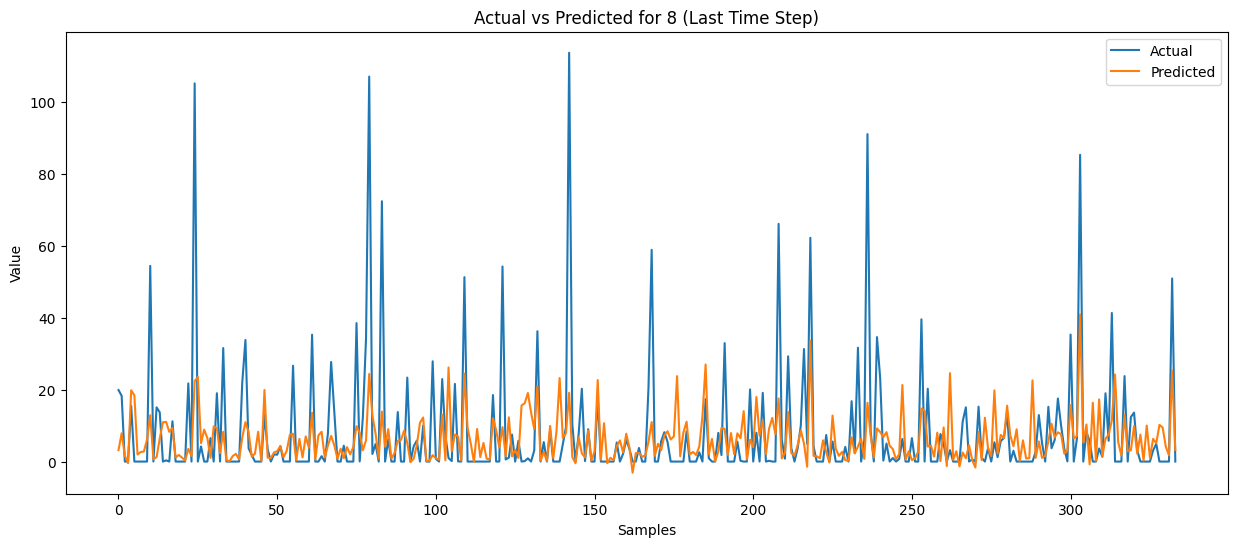

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' column is datetime
df.set_index('date', inplace=True)

# Normalize data (MinMax Scaling)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Function to create sequences
def create_sequences(data, time_steps=30, horizon=7):
    X, y = [], []
    for i in range(len(data) - time_steps - horizon + 1):
        X.append(data[i:i + time_steps, :])  # Input: Features for time_steps
        y.append(data[i + time_steps:i + time_steps + horizon, :])  # Output: Predict next horizon steps
    return np.array(X), np.array(y)

# Define sequence parameters
time_steps = 30  # Past 30 days
horizon = 7      # Predict next 7 days

# Create input/output sequences
X, y = create_sequences(scaled_data, time_steps, horizon)

# Reshape y to match the output shape (flatten horizon and features)
y = y.reshape(y.shape[0], -1)  # Shape: (samples, horizon * features)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Bi-LSTM model
model = Sequential()

# First Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(y_train.shape[1]))  # Predict all horizon * features values

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_split=0.1,
                    epochs=50, 
                    batch_size=32, 
                    callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.5f}, Mean Absolute Error: {mae:.5f}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions
predictions = model.predict(X_test)

# Reshape predictions and test values back to original scale
predictions = predictions.reshape(-1, horizon, df.shape[1])
y_test = y_test.reshape(-1, horizon, df.shape[1])

# Inverse scaling
predictions_original = scaler.inverse_transform(predictions.reshape(-1, df.shape[1]))
predictions_original = predictions_original.reshape(-1, horizon, df.shape[1])

y_test_original = scaler.inverse_transform(y_test.reshape(-1, df.shape[1]))
y_test_original = y_test_original.reshape(-1, horizon, df.shape[1])

# Plot actual vs predicted for the last time step of each sequence
for i, feature in enumerate(df.columns):
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_original[:, -1, i], label='Actual')
    plt.plot(predictions_original[:, -1, i], label='Predicted')
    plt.title(f"Actual vs Predicted for {feature} (Last Time Step)")
    plt.xlabel("Samples")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


In [9]:
# Step 7: Print the metrics of the model after training
print("\nModel Metrics:")
print(f"Training Loss: {round(history.history['loss'][-1], 5)}")
print(f"Validation Loss: {round(history.history['val_loss'][-1], 5)}")
print(f"Training MAE: {round(history.history['mae'][-1], 5)}")
print(f"Validation MAE: {round(history.history['val_mae'][-1], 5)}")


Model Metrics:
Training Loss: 0.00895
Validation Loss: 0.00739
Training MAE: 0.05747
Validation MAE: 0.04688


In [10]:
import pandas as pd
import numpy as np

def predict_on_date(model, df, scaler, window_size, date_input):
    """
    Predicts values for a specific date, either by continuing from available data or extrapolating forward.
    """
    # Convert input date to datetime and ensure the dataset index is datetime
    date_input = pd.to_datetime(date_input)
    df.index = pd.to_datetime(df.index)

    print(f"Looking for predictions for the date: {date_input}")

    if date_input in df.index:
        # Prediction for a date within the dataset range
        end_index = df.index.get_loc(date_input)
        print(f"Prediction for the entered date {date_input}:")
        # Extract the last `window_size` days as input
        data_sequence = df.iloc[end_index - window_size + 1 : end_index + 1].values
        predict_single_day(model, df, scaler, data_sequence, date_input)

    else:
        # Prediction for a future date (extrapolation)
        print(f"The entered date {date_input} is not in the dataset.")
        recent_date = df.index[-1]
        print(f"Most recent date in the dataset: {recent_date}")

        # Calculate how many days to predict forward
        num_days_to_predict = (date_input - recent_date).days
        print(f"Days to predict forward: {num_days_to_predict}")

        # Initialize the input sequence with the most recent window_size days
        data_sequence = df.iloc[-window_size:].values

        # Predict forward, one day at a time
        for i in range(num_days_to_predict):
            predicted_date = recent_date + pd.Timedelta(days=i + 1)
            data_sequence = predict_single_day(model, df, scaler, data_sequence, predicted_date)

def predict_single_day(model, df, scaler, data_sequence, predicted_date):
    """
    Predicts a single day based on the input sequence and updates the sequence.
    """
    # Step 1: Normalize the data sequence
    data_sequence_scaled = scaler.transform(data_sequence)

    # Step 2: Reshape input to match the model's expected input: (1, window_size, features)
    data_sequence_scaled = data_sequence_scaled.reshape(1, data_sequence_scaled.shape[0], data_sequence_scaled.shape[1])

    # Step 3: Predict using the trained model
    prediction = model.predict(data_sequence_scaled)

    # Step 4: Inverse transform to original scale
    prediction_original = scaler.inverse_transform(prediction.reshape(-1, df.shape[1]))
    prediction_original = prediction_original.reshape(-1, df.shape[1])

    # Step 5: Print the results
    if predicted_date:
        print(f"Prediction for {predicted_date.date()}:")
        for i, feature in enumerate(df.columns):
            print(f"GID_2 {feature}: {prediction_original[0, i]:.2f}")

    # Step 6: Update data_sequence with the new prediction for the next step
    # Append the prediction and drop the oldest value
    updated_sequence = np.append(data_sequence[1:], prediction_original, axis=0)
    return updated_sequence

# Example usage (assuming model, df, scaler, and window_size are defined)
date_input = input("Please enter the date (format: YYYY-MM-DD) to predict the values for: ")

# Call the prediction function
predict_on_date(model, df, scaler, window_size=30, date_input=date_input)


Please enter the date (format: YYYY-MM-DD) to predict the values for:  2024-12-20


Looking for predictions for the date: 2024-12-20 00:00:00
The entered date 2024-12-20 00:00:00 is not in the dataset.
Most recent date in the dataset: 2024-08-30 00:00:00
Days to predict forward: 112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for 2024-08-31:
GID_2 1: 14.32
GID_2 2: 12.41
GID_2 3: 13.89
GID_2 4: 11.40
GID_2 5: 11.27
GID_2 6: 9.77
GID_2 7: 9.81
GID_2 8: 13.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
Prediction for 2024-09-01:
GID_2 1: 10.06
GID_2 2: 8.81
GID_2 3: 9.92
GID_2 4: 8.50
GID_2 5: 8.40
GID_2 6: 7.66
GID_2 7: 8.21
GID_2 8: 9.80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for 2024-09-02:
GID_2 1: 7.69
GID_2 2: 6.89
GID_2 3: 8.00
GID_2 4: 6.50
GID_2 5: 6.64
GID_2 6: 6.31
GID_2 7: 7.30
GID_2 8: 7.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for 2024-09-03:
GID_2 1: 8.23
GID_2 2: 8.10
GID_2 3: 9.04
GID_2 4: 7.89
GID_2 5: 7.74
GID_2 6: 7.04
GID_2 7: 8.34
GID_2 8: 8.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for 2024-09-04:
GID_2 1: 8.97
GID_2

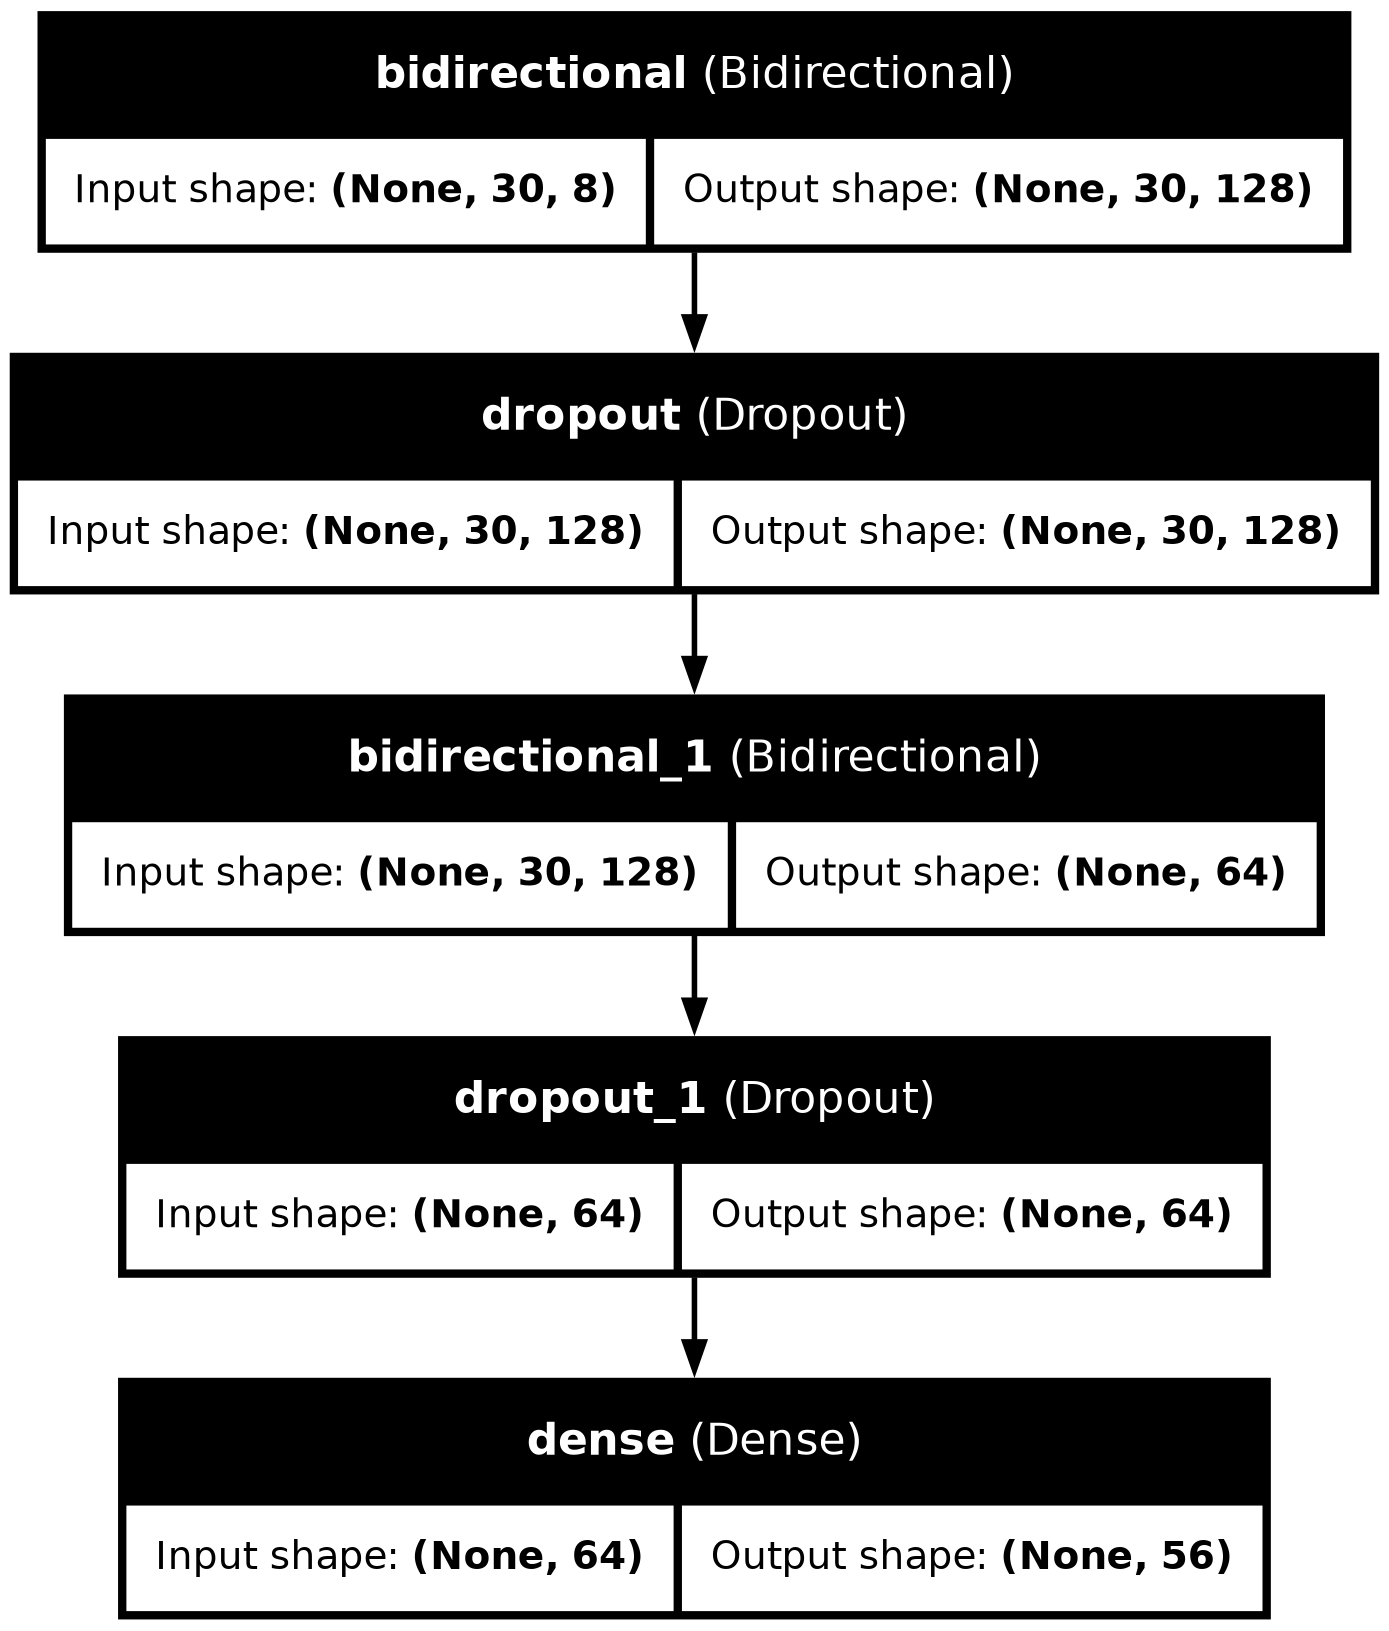

In [11]:
from tensorflow.keras.utils import plot_model

# Save a diagram of the model
plot_model(
    model,
    to_file='model_diagram.png',
    show_shapes=True,  # Display input/output shapes
    show_layer_names=True  # Display layer names
)
